In [1]:
!pip install category_encoders
!pip install pdpbox
from pdpbox.pdp import pdp_interact, pdp_interact_plot

     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 57.7MB 104kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=83bbcd9422fc6d6d7821bf78b13544775c4d25b015bcf3a419e3bbe395f42218
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [2]:
data_url = 'https://query.data.world/s/dbkcq4idvugkfhoyx4ngann5ycr4jl'

In [3]:
import pandas as pd
df = pd.read_csv(data_url)

In [4]:
def wrangle(df):
  df = df.copy()

  #Drop rows that contain null values in every column
  df.dropna(axis=0,how='all', inplace=True)

  #Drop rows that contain an outlier value for 'snatch' column where column is 'male'
  male_sn = df[(df['gender'] == 'Male') & (df['snatch'] >= 500)].index
  df.drop(male_sn , inplace=True)

  #Drop rows that contain an outlier value for 'candj' column where column is 'male'
  male_cj = df[(df['gender'] == 'Male') & (df['candj'] >= 600)].index
  df.drop(male_cj , inplace=True)

  #Drop rows that contain an outlier value for 'backsq' column where column is 'male'
  male_bsq = df[(df['gender'] == 'Male') & (df['backsq'] >= 1160)].index
  df.drop(male_bsq , inplace=True)

  #Drop rows that contain an outlier value for 'deadlift' column where column is 'male' I'm eliminating values that are (beyond the world record deadlift
  #amount(1110) minus 100 pounds) The reason is that it's not typical for Olympic weightlifters to try or even 
  male_dl = df[(df['gender'] == 'Male') & (df['deadlift'] >= 1010)].index
  df.drop(male_dl , inplace=True)

  #Drop rows that contain an outlier value for 'snatch' column where column is 'female'
  female_sn = df[(df['gender'] == 'Female') & (df['snatch'] >= 355)].index
  df.drop(female_sn , inplace=True)

  #Drop rows that contain an outlier value for 'candj' column where column is 'female'
  female_cj = df[(df['gender'] == 'Female') & (df['candj'] >= 435)].index
  df.drop(female_cj , inplace=True)

  #Drop rows that contain an outlier value for 'backsq' column where column is 'female'
  female_bsq = df[(df['gender'] == 'Female') & (df['backsq'] >= 603)].index
  df.drop(female_bsq , inplace=True)

  #Drop rows that contain an outlier value for 'deadlift' column where column is 'female' and again similar to the male deadlift, I am dropping
  #outliers that are above the world record female deadlift minus 100 pounds
  female_dl = df[(df['gender'] == 'Female') & (df['deadlift'] >= 583)].index
  df.drop(female_dl , inplace=True)

  df.dropna(subset = ['snatch', 'candj', 'deadlift', 'backsq'], how='any', inplace=True)

  #Drop rows that contain an outlier value for 'age' column. I'm definining an outlier value as
  # anything above 65. While the sport of Olympic weightlifting is very inclusive and offers competition age divisions for everyone
  #it is less meaningful to evaluate competitive "potential" in the sport beyond a certain point where there is not much variation in performance.
  #Beyond a certain age, simply showing up and competing is remarkable in its own right
  age_limit_upper = df[(df['age'] >= 65)].index 
  df.drop(age_limit_upper, inplace=True)
 
  #Drop rows where the athlete is not an adult
  age_limit_lower = df[(df['age'] < 18)].index 
  df.drop(age_limit_lower, inplace=True)
  #Replace the content of background with the number of words it contains
  #df['background_count'] = df['background'].str.split(' ').str.len()

  #drop rows in candj, snatch, backsq, and deadlift columns that are below the minimum weight of the women's bar
  #a severely injured participant who still desire to participate would at least lift the bar without any weights loaded on it
  
  lift_subset = df[(df['backsq'] <= 33) | (df['deadlift'] <= 33) | (df['candj'] <= 33) | (df['snatch'] <= 33)].index
  df.drop(lift_subset, inplace=True)                                                                     
                                                       
  return df



In [5]:
df = wrangle(df)

In [6]:
df["clj_to_bsq_ratio"] = df['candj']/df['backsq']

In [7]:
def weightlifting_potential(row):
    if row['clj_to_bsq_ratio'] >= .70:
        return 'potential'
    #elif row['clj_to_bsq_ratio'] < .77 and row['clj_to_bsq_ratio']  >= .72:
     #   return 'some potential'
    else:
        return 'no potential'

In [8]:
df['talent'] = df.apply(weightlifting_potential, axis=1)

In [9]:
df['sn_clj'] = df['snatch']/df['candj']

In [10]:
#Create a new column equal to True or False depending on whether or not an athlete described their experience with Crossfit as life changing
df['experience_type'] = df['experience'].str.contains('life changing') 

In [11]:
#Replance NaN values with False. This is an appropriate replacement in my attempts to feature engineer this binary column. If an athlete did not respond to 
#the question, then the likelihood that they had a profound experience is greatly reduced.
df['experience_type'] = df['experience_type'].fillna(False)

In [12]:
def wrangle_two(df):
  df = df.copy()
  #Create a new column equal to True or False depending on whether or not an athlete described their experience with Crossfit as life changing
  df['experience_type'] = df['experience'].str.contains('life changing') 
  #Replance NaN values with False. This is an appropriate replacement in my attempts to feature engineer this binary column. If an athlete did not respond to 
  #the question, then the likelihood that they had a profound experience is greatly reduced.
  df['experience_type'] = df['experience_type'].fillna(False)
  df['experience_type'] = df['experience_type'].astype(int)
  df['background_type'] = df['background'].str.contains('no athletic background besides CrossFit') 
  df['background_type'] = df['background_type'].fillna(False)
  df['schedule_type'] = df['schedule'].str.contains('I do multiple workouts in a day 3+ times a week') 
  df['schedule_type'] = df['schedule_type'].fillna(False)
  df['train_description'] = df['train'].str.contains('I workout mostly at a CrossFit Affiliate') 
  df['train_description'] = df['train_description'].fillna(False)
  return df

In [13]:
df = wrangle_two(df)

In [14]:
df = df.drop(columns=['candj', 'backsq', 'retrieved_datetime', 'clj_to_bsq_ratio', 'athlete_id', 'name', 'experience'])

In [15]:
df['experience_type'].dtypes

dtype('int64')

In [16]:
df = df.drop(columns=['background', 'schedule', 'train'])

In [17]:
df.head()

,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,snatch,deadlift,pullups,eat,howlong,talent,sn_clj,experience_type,background_type,schedule_type,train_description
3,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,200.0,375.0,25.0,I eat 1-3 full cheat meals per week|,4+ years|,potential,0.816327,1,False,False,True
5,NaN,NaN,NaN,Male,37.0,73.0,230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,435.0,NaN,I eat strict Paleo|,4+ years|,no potential,0.754717,1,False,False,True
9,NaN,NaN,NaN,Male,40.0,68.0,177.0,205.0,614.0,NaN,1647.0,332.0,NaN,1361.0,185.0,365.0,NaN,I eat quality foods but don't measure the amount|,2-4 years|,no potential,0.822222,0,False,False,True
12,NaN,NaN,NaN,Male,31.0,65.0,150.0,119.0,417.0,103.0,971.0,421.0,61.0,1211.0,225.0,465.0,81.0,I eat quality foods but don't measure the amou...,2-4 years|,potential,0.775862,1,False,False,True
18,Central East,New Species CrossFit,CrossFit New Species,Male,30.0,70.0,155.0,NaN,544.0,NaN,1455.0,NaN,NaN,1140.0,95.0,335.0,NaN,NaN,NaN,potential,0.542857,0,False,False,False


In [18]:
target = 'talent'
y = df[target]
X = df.drop(target, axis=1)

In [19]:
features= ['age', 'snatch', 'deadlift']

X_new = X[features]

In [20]:
X_new.shape

(81154, 3)

In [21]:
df['age'].isnull().sum()

0

In [22]:
df['snatch'].isnull().sum()

0

In [23]:
df['snatch'].isnull().sum()

0

In [24]:
df['experience_type'].isnull().sum()

0

In [25]:
# Import the train_test_split utility
#from sklearn.model_selection import train_test_split
# Create the "remaining" and test datasets
from sklearn.model_selection import train_test_split

X_initial_train, X_test, y_initial_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42)

In [26]:
# Create the train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_initial_train, y_initial_train, test_size=0.2, random_state=42)

In [27]:
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

In [28]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=41, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=41,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
      

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


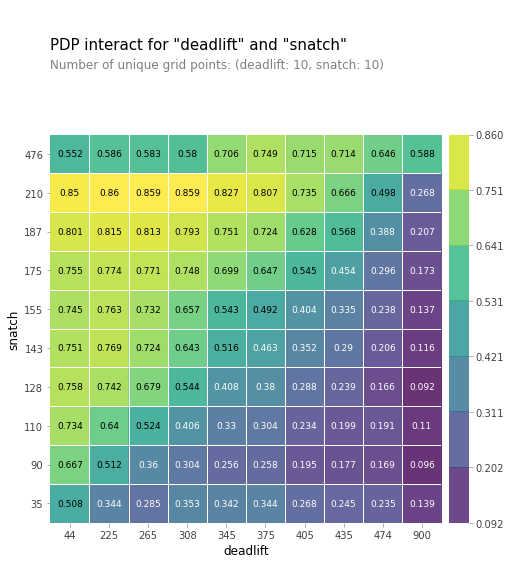

In [29]:
features= ['deadlift', 'snatch']

interact= pdp_interact(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [30]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [31]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==1.0.1
scikit-learn==0.22.2.post1
category_encoders==2.2.2
xgboost==0.90


In [32]:
from sklearn.metrics import accuracy_score
test_acc =  accuracy_score(y_test, pipeline.predict(X_test))

print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6392705316986015


In [33]:
from google.colab import files
files.download('pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>